# Определение перспективного тарифа для телеком компании

Компания — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Необходимо сделать предварительный анализ тарифов на выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше. Проверить гипотезы, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются; средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.


## Изучение данных из файлов

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math
import matplotlib.pyplot as plt

data_calls = pd.read_csv('/datasets/calls.csv')
data_internet = pd.read_csv('/datasets/internet.csv')
data_messages = pd.read_csv('/datasets/messages.csv')
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
data_users = pd.read_csv('/datasets/users.csv')

data_list = [data_calls, data_internet, data_messages, data_tariffs, data_users]
for data in data_list:
    data.info()
    display(data.head())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Данные представлены в 5 таблицах и содержат информацию о потреблении услуг связи 500 пользователей. Данные в таблицах имеют ключ для идентификации user_id. В некторых столбцах наблюдаются пропуски.

## Подготовка данных

В таблице data_users в столбце churn_date много пропусков. В описании указано, что это дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных). Выгрузка произведена за 2018 год, заплоним пропущенные даты последней датой периода выгрузки данных. В начале проверим выборочно предельные даты выборки в выгрузке:

In [2]:
print(data_calls['call_date'].min())
print(data_calls['call_date'].max())

2018-01-01
2018-12-31


Даты соответствуют. Заполняем пропуски

In [3]:
date_for_fill = data_calls['call_date'].max()
data_users['churn_date'] = data_users['churn_date'].fillna(date_for_fill)
data_users['churn_date'].isna().sum()


0

Значения столбцов с датами во всех таблицах хранятся в строковом формате, переведем их в формат datetime64.

In [4]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'])
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'])
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'])
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'])
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'])
for data in data_list:
    data.info()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), i

В таблице data_internet обнаружен столбец Unnamed: 0, дублирующий столбец с индексами. Видимо он образовался в результате какой-то ошибки при выгрузке или копировании данных. Удалим его.

In [5]:
data_internet.drop('Unnamed: 0', axis=1, inplace=True)
data_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Для возможности группировки потребления услуг по месяцам, добавим в таблицы столбец month с месяцем использования услуги 

In [6]:
data_calls['month'] = data_calls['call_date'].dt.month
data_internet['month'] = data_internet['session_date'].dt.month
data_messages['month'] = data_messages['message_date'].dt.month
print(data_calls.head())
print(data_internet.head())
print(data_messages.head())

       id  call_date  duration  user_id  month
0  1000_0 2018-07-25      0.00     1000      7
1  1000_1 2018-08-17      0.00     1000      8
2  1000_2 2018-06-11      2.85     1000      6
3  1000_3 2018-09-21     13.80     1000      9
4  1000_4 2018-12-15      5.18     1000     12
       id  mb_used session_date  user_id  month
0  1000_0   112.95   2018-11-25     1000     11
1  1000_1  1052.81   2018-09-07     1000      9
2  1000_2  1197.26   2018-06-25     1000      6
3  1000_3   550.27   2018-08-22     1000      8
4  1000_4   302.56   2018-09-24     1000      9
       id message_date  user_id  month
0  1000_0   2018-06-27     1000      6
1  1000_1   2018-10-08     1000     10
2  1000_2   2018-08-04     1000      8
3  1000_3   2018-06-16     1000      6
4  1000_4   2018-12-05     1000     12


Поскольку «Мегалайн» всегда округляет секунды до минут, и каждый звонок округляется отдельно, добавим в таблицу data_calls столбец duration_round со значениями столбца duration округленными в большую сторону до целого и типом int

In [7]:
data_calls['duration_round'] = data_calls['duration'].apply(math.ceil)
data_calls.info()
data_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 6 columns):
id                202607 non-null object
call_date         202607 non-null datetime64[ns]
duration          202607 non-null float64
user_id           202607 non-null int64
month             202607 non-null int64
duration_round    202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.3+ MB


,id,call_date,duration,user_id,month,duration_round
0,1000_0,2018-07-25,0.00,1000,7,0
1,1000_1,2018-08-17,0.00,1000,8,0
2,1000_2,2018-06-11,2.85,1000,6,3
3,1000_3,2018-09-21,13.80,1000,9,14
4,1000_4,2018-12-15,5.18,1000,12,6


Посчитаем для каждого пользователя количество отправленных сообщений по месяцам

In [8]:
spend_mess_month = data_messages.groupby(
    by=['user_id', 'month']).agg(
        count_messages=('month', 'count')).reset_index()
spend_mess_month.info()
spend_mess_month.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
user_id           2717 non-null int64
month             2717 non-null int64
count_messages    2717 non-null int64
dtypes: int64(3)
memory usage: 63.8 KB


,user_id,month,count_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Посчитаем для каждого пользователя количество звонков и израсходованных минут по месяцам

In [9]:
spend_call_month = data_calls.groupby(
    by=['user_id', 'month']).agg(
        count_call=('duration_round', 'count'), sum_minutes=('duration_round', 'sum')).reset_index()
spend_call_month.info()
spend_call_month.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 4 columns):
user_id        3174 non-null int64
month          3174 non-null int64
count_call     3174 non-null int64
sum_minutes    3174 non-null int64
dtypes: int64(4)
memory usage: 99.3 KB


,user_id,month,count_call,sum_minutes
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


Посчитаем для каждого пользователя количество израсходованного интернет-трафика по месяцам

In [10]:
spend_internet_month = data_internet.groupby(
    by=['user_id', 'month']).agg(
        sum_mb=('mb_used', 'sum')).reset_index()
spend_internet_month.info()
spend_internet_month.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 3 columns):
user_id    3203 non-null int64
month      3203 non-null int64
sum_mb     3203 non-null float64
dtypes: float64(1), int64(2)
memory usage: 75.2 KB


,user_id,month,sum_mb
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


«Мегалайн» округляет мегабайты до гигабайт, отдельные сессии не считаются, общая сумма за месяц округляется в бо́льшую сторону. Добавим в таблицу spend_internet_month столбец с округленным трафиком.

In [11]:
spend_internet_month['traffic_round'] = (spend_internet_month['sum_mb'] / 1024).apply(math.ceil)
spend_internet_month.info()
spend_internet_month.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 4 columns):
user_id          3203 non-null int64
month            3203 non-null int64
sum_mb           3203 non-null float64
traffic_round    3203 non-null int64
dtypes: float64(1), int64(3)
memory usage: 100.2 KB


,user_id,month,sum_mb,traffic_round
0,1000,5,2253.49,3
1,1000,6,23233.77,23
2,1000,7,14003.64,14
3,1000,8,14055.93,14
4,1000,9,14568.91,15


Для проведения анализа создадим сводную таблицу merge_data с интересующими данными. Объединим таблицы со звонками и сообщениями

In [12]:
merge_data = spend_call_month.merge(spend_mess_month, on=['user_id', 'month'], how='outer')
merge_data.info()
merge_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 0 to 3212
Data columns (total 5 columns):
user_id           3213 non-null int64
month             3213 non-null int64
count_call        3174 non-null float64
sum_minutes       3174 non-null float64
count_messages    2717 non-null float64
dtypes: float64(3), int64(2)
memory usage: 150.6 KB


,user_id,month,count_call,sum_minutes,count_messages
0,1000,5,22.0,159.0,22.0
1,1000,6,43.0,172.0,60.0
2,1000,7,47.0,340.0,75.0
3,1000,8,52.0,408.0,81.0
4,1000,9,58.0,466.0,57.0


Добавим данные по использованию интернет

In [13]:
merge_data = merge_data.merge(spend_internet_month, on=['user_id', 'month'], how='outer')
merge_data.info()
merge_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 7 columns):
user_id           3214 non-null int64
month             3214 non-null int64
count_call        3174 non-null float64
sum_minutes       3174 non-null float64
count_messages    2717 non-null float64
sum_mb            3203 non-null float64
traffic_round     3203 non-null float64
dtypes: float64(5), int64(2)
memory usage: 200.9 KB


,user_id,month,count_call,sum_minutes,count_messages,sum_mb,traffic_round
0,1000,5,22.0,159.0,22.0,2253.49,3.0
1,1000,6,43.0,172.0,60.0,23233.77,23.0
2,1000,7,47.0,340.0,75.0,14003.64,14.0
3,1000,8,52.0,408.0,81.0,14055.93,14.0
4,1000,9,58.0,466.0,57.0,14568.91,15.0


Добавляем данные с информацией по пользователям

In [14]:
#merge_data = data_users.merge(merge_data, on='user_id', how='outer')
merge_data = data_users[['user_id','city','tariff']].merge(merge_data, on='user_id', how='outer')
merge_data.info()
merge_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 9 columns):
user_id           3216 non-null int64
city              3216 non-null object
tariff            3216 non-null object
month             3214 non-null float64
count_call        3174 non-null float64
sum_minutes       3174 non-null float64
count_messages    2717 non-null float64
sum_mb            3203 non-null float64
traffic_round     3203 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 251.2+ KB


,user_id,city,tariff,month,count_call,sum_minutes,count_messages,sum_mb,traffic_round
0,1000,Краснодар,ultra,5.0,22.0,159.0,22.0,2253.49,3.0
1,1000,Краснодар,ultra,6.0,43.0,172.0,60.0,23233.77,23.0
2,1000,Краснодар,ultra,7.0,47.0,340.0,75.0,14003.64,14.0
3,1000,Краснодар,ultra,8.0,52.0,408.0,81.0,14055.93,14.0
4,1000,Краснодар,ultra,9.0,58.0,466.0,57.0,14568.91,15.0


Добавим в сводную таблицу данные по тарифным планам.Предварительно переименуем столбец tariff_name на tariff в таблице data_tariffs, для удобства объединения таблиц

In [15]:
data_tariffs.rename(columns={'tariff_name' : 'tariff'}, inplace=True)
merge_data = merge_data.merge(data_tariffs, on='tariff', how='outer')
merge_data.info()
merge_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 16 columns):
user_id                  3216 non-null int64
city                     3216 non-null object
tariff                   3216 non-null object
month                    3214 non-null float64
count_call               3174 non-null float64
sum_minutes              3174 non-null float64
count_messages           2717 non-null float64
sum_mb                   3203 non-null float64
traffic_round            3203 non-null float64
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute           3216 non-null int64
dtypes: float64(6), int64(8), object(2)
memory usage: 427.1+ KB


,user_id,city,tariff,month,count_call,sum_minutes,count_messages,sum_mb,traffic_round,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,Краснодар,ultra,5.0,22.0,159.0,22.0,2253.49,3.0,1000,30720,3000,1950,150,1,1
1,1000,Краснодар,ultra,6.0,43.0,172.0,60.0,23233.77,23.0,1000,30720,3000,1950,150,1,1
2,1000,Краснодар,ultra,7.0,47.0,340.0,75.0,14003.64,14.0,1000,30720,3000,1950,150,1,1
3,1000,Краснодар,ultra,8.0,52.0,408.0,81.0,14055.93,14.0,1000,30720,3000,1950,150,1,1
4,1000,Краснодар,ultra,9.0,58.0,466.0,57.0,14568.91,15.0,1000,30720,3000,1950,150,1,1


In [16]:
merge_data.tail()

,user_id,city,tariff,month,count_call,sum_minutes,count_messages,sum_mb,traffic_round,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
3211,1498,Владикавказ,smart,10.0,41.0,247.0,42.0,20579.36,21.0,50,15360,500,550,200,3,3
3212,1499,Пермь,smart,9.0,9.0,70.0,11.0,1845.75,2.0,50,15360,500,550,200,3,3
3213,1499,Пермь,smart,10.0,68.0,449.0,48.0,17788.51,18.0,50,15360,500,550,200,3,3
3214,1499,Пермь,smart,11.0,74.0,612.0,59.0,17963.31,18.0,50,15360,500,550,200,3,3
3215,1499,Пермь,smart,12.0,69.0,492.0,66.0,13055.58,13.0,50,15360,500,550,200,3,3


Посмотрим на пропуски в сводной таблице

In [17]:
merge_data.isna().sum()

user_id                    0
city                       0
tariff                     0
month                      2
count_call                42
sum_minutes               42
count_messages           499
sum_mb                    13
traffic_round             13
messages_included          0
mb_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
dtype: int64

In [18]:
merge_data[merge_data['month'].isna()]

,user_id,city,tariff,month,count_call,sum_minutes,count_messages,sum_mb,traffic_round,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
243,1128,Волжский,ultra,NaN,NaN,NaN,NaN,NaN,NaN,1000,30720,3000,1950,150,1,1
2619,1371,Омск,smart,NaN,NaN,NaN,NaN,NaN,NaN,50,15360,500,550,200,3,3


Найдены 2 пользователя по одному для каждого тарифного плана, с отсутствием потребления услуг связи. Оба абонента пользовались тарифом только в декабре 2018 и соответственно платили абонентскую плату, возможно они пользовались, например, только входящей связью. Добавим для них месяц использования услуг - 12.

In [19]:
merge_data['month'] = merge_data['month'].fillna(12)
merge_data['month'].isna().sum()

0

Остались пропуски в столбцах count_call, sum_minutes, count_messages, sum_mb, traffic_round. Очевидно, что пропуски здесь связаны с отсутствием использования данных услуг у некторых пользователей. Заполним пропущенные значения 0.    

In [20]:
merge_data = merge_data.fillna(0)
merge_data.isna().sum()

user_id                  0
city                     0
tariff                   0
month                    0
count_call               0
sum_minutes              0
count_messages           0
sum_mb                   0
traffic_round            0
messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
dtype: int64

In [21]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 16 columns):
user_id                  3216 non-null int64
city                     3216 non-null object
tariff                   3216 non-null object
month                    3216 non-null float64
count_call               3216 non-null float64
sum_minutes              3216 non-null float64
count_messages           3216 non-null float64
sum_mb                   3216 non-null float64
traffic_round            3216 non-null float64
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute           3216 non-null int64
dtypes: float64(6), int64(8), object(2)
memory usage: 427.1+ KB


После объединения таблиц и образования в некторых столбцах пропусков в них изменился тип храненяи данных на float64. Вернем для столбцов month, count_call, sum_minutes, count_messages, traffic_round изначальные типы int.

In [22]:
list_type_change = ['month', 'count_call', 'sum_minutes', 'count_messages', 'traffic_round']
for column in list_type_change:
    merge_data[column] = merge_data[column].astype('int')
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 16 columns):
user_id                  3216 non-null int64
city                     3216 non-null object
tariff                   3216 non-null object
month                    3216 non-null int64
count_call               3216 non-null int64
sum_minutes              3216 non-null int64
count_messages           3216 non-null int64
sum_mb                   3216 non-null float64
traffic_round            3216 non-null int64
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute           3216 non-null int64
dtypes: float64(1), int64(13), object(2)
memory usage: 427.1+ KB


In [23]:
merge_data.head()

,user_id,city,tariff,month,count_call,sum_minutes,count_messages,sum_mb,traffic_round,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,Краснодар,ultra,5,22,159,22,2253.49,3,1000,30720,3000,1950,150,1,1
1,1000,Краснодар,ultra,6,43,172,60,23233.77,23,1000,30720,3000,1950,150,1,1
2,1000,Краснодар,ultra,7,47,340,75,14003.64,14,1000,30720,3000,1950,150,1,1
3,1000,Краснодар,ultra,8,52,408,81,14055.93,14,1000,30720,3000,1950,150,1,1
4,1000,Краснодар,ultra,9,58,466,57,14568.91,15,1000,30720,3000,1950,150,1,1


Посчитаем помесячную выручку с каждого пользователя и добавим данные в новый столбец profit_month. Сделаем это с помощью функции calc_profit

In [24]:
# Функция подсчета выручки. Вычитает бесплатный лимит из суммарного количества звонков,
# сообщений и интернет-трафик, остаток умножает на стоимость из тарифного плана,
# прибавляет абонентскую плату

def calc_profit(row):
    paid_minutes = row['sum_minutes'] - row['minutes_included']
    paid_messages = row['count_messages'] - row['messages_included']
    paid_gb = row['traffic_round'] - (row['mb_per_month_included'] // 1024)
    if (paid_minutes < 0):
        paid_minutes = 0       
    if (paid_messages < 0):
        paid_messages = 0        
    if (paid_gb < 0):
        paid_gb = 0        
    total_profit = row['rub_monthly_fee'] + paid_minutes * row['rub_per_minute'] + (
            paid_messages * row['rub_per_message']) + (
            paid_gb * row['rub_per_gb'])
    return total_profit

    

In [25]:
merge_data['profit_month'] = merge_data.apply(calc_profit, axis=1)
merge_data.info()
merge_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 17 columns):
user_id                  3216 non-null int64
city                     3216 non-null object
tariff                   3216 non-null object
month                    3216 non-null int64
count_call               3216 non-null int64
sum_minutes              3216 non-null int64
count_messages           3216 non-null int64
sum_mb                   3216 non-null float64
traffic_round            3216 non-null int64
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute           3216 non-null int64
profit_month             3216 non-null int64
dtypes: float64(1), int64(14), object(2)
memory usage: 452.2+ KB


,user_id,city,tariff,month,count_call,sum_minutes,count_messages,sum_mb,traffic_round,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit_month
0,1000,Краснодар,ultra,5,22,159,22,2253.49,3,1000,30720,3000,1950,150,1,1,1950
1,1000,Краснодар,ultra,6,43,172,60,23233.77,23,1000,30720,3000,1950,150,1,1,1950
2,1000,Краснодар,ultra,7,47,340,75,14003.64,14,1000,30720,3000,1950,150,1,1,1950
3,1000,Краснодар,ultra,8,52,408,81,14055.93,14,1000,30720,3000,1950,150,1,1,1950
4,1000,Краснодар,ultra,9,58,466,57,14568.91,15,1000,30720,3000,1950,150,1,1,1950


In [26]:
merge_data.tail()

,user_id,city,tariff,month,count_call,sum_minutes,count_messages,sum_mb,traffic_round,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit_month
3211,1498,Владикавказ,smart,10,41,247,42,20579.36,21,50,15360,500,550,200,3,3,1750
3212,1499,Пермь,smart,9,9,70,11,1845.75,2,50,15360,500,550,200,3,3,550
3213,1499,Пермь,smart,10,68,449,48,17788.51,18,50,15360,500,550,200,3,3,1150
3214,1499,Пермь,smart,11,74,612,59,17963.31,18,50,15360,500,550,200,3,3,1513
3215,1499,Пермь,smart,12,69,492,66,13055.58,13,50,15360,500,550,200,3,3,598


## Анализ данных

Посчитаем среднее количество используемых услуг (минут разговора, сообщений, интернет-трафика) и выручки с пользователей, дисперсию и стандартное отклонение. 

In [27]:
list_parametr = ['sum_minutes', 'count_messages', 'sum_mb', 'profit_month']
list_head_parametr = ['Использование минут', 'Использование сообщений',
                      'Использование мегабайт', 'Выручка с пользователя']

for parametr, head_parametr in zip(list_parametr, list_head_parametr):
    print(head_parametr)
    tb_output = (round(merge_data.pivot_table(
            index='tariff', values=parametr, 
            aggfunc=['mean', 'var', 'std']).reset_index(), 2))
    tb_output.columns = ['Тариф', 'Среднее', 'Дисперсия', 'Стандарт.откл.']
    print(tb_output)
    print()

Использование минут
   Тариф  Среднее  Дисперсия  Стандарт.откл.
0  smart   417.75   36281.39          190.48
1  ultra   526.09  101052.49          317.89

Использование сообщений
   Тариф  Среднее  Дисперсия  Стандарт.откл.
0  smart    33.37     796.96           28.23
1  ultra    49.31    2285.42           47.81

Использование мегабайт
   Тариф   Среднее     Дисперсия  Стандарт.откл.
0  smart  16201.12  3.456484e+07         5879.19
1  ultra  19449.06  1.020321e+08        10101.10

Выручка с пользователя
   Тариф  Среднее  Дисперсия  Стандарт.откл.
0  smart  1289.64  669730.76          818.37
1  ultra  2070.03  141387.71          376.02



Пользователи тарифа Ультра в среднем используют бо́льшие объемы услуг. Минут использовано на 26% больше, сообщений на 48%, мегабайт на 20%. При этом стандартное отклонение по потреблению услуг у пользователей тарифа Ультра еще больше, разница с тарифом Смарт по минутам - 67%, по сообщениям - 71%, по использованию мегабайт - 72%. Это говорит о том что разброс значений потребления у пользователей тарифа Ультра шире. Средняя выручка с пользователя тарифа Ультра больше, но при этом она близка к размеру абонентской платы и имеет относительно небольшое стандартное отклонение, что говорит о небольшом разбросе этого параметра. В то же время у пользователей тарифа Смарт средняя выручка превышает абонентскую плату в 2.3 раза и имеет относительно большой разброс.

Построим гистограммы распределений использования услуг и выручки с пользователей

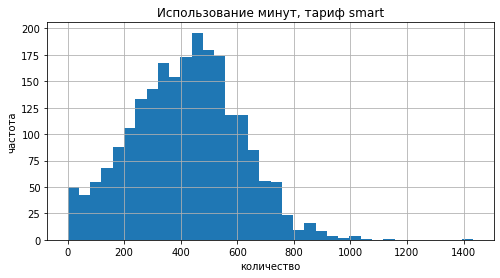

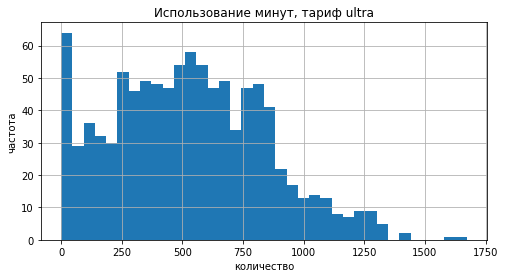

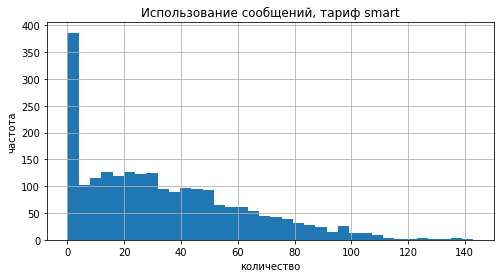

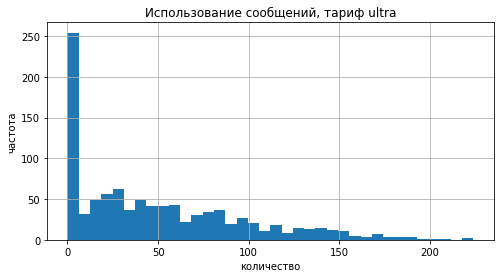

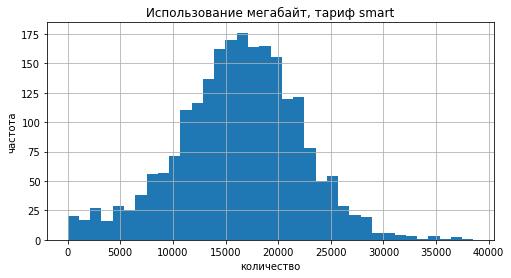

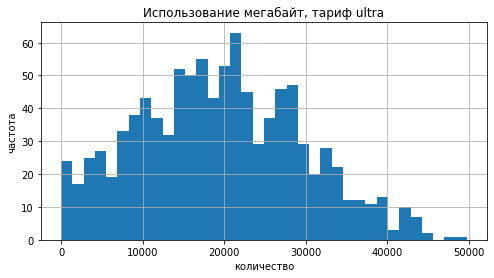

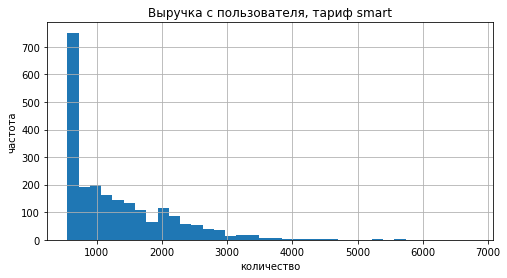

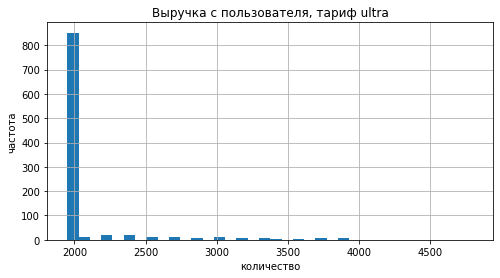

In [28]:
list_tariff_name = data_tariffs['tariff'].to_list()

for parametr, head_parametr in zip(list_parametr, list_head_parametr):
    for tariff_name in list_tariff_name:
        fig, ax = plt.subplots()
        ax.hist(merge_data.query('tariff == @tariff_name')[parametr], bins=36)
        ax.set_title(head_parametr + ', тариф ' + tariff_name)
        ax.set_xlabel('количество')
        ax.set_ylabel('частота')
        ax.grid()
        fig.set_figheight(4)
        fig.set_figwidth(8)
        plt.show()  

По гистограммам видно что распределение потребления услуг на разных тарифах несколько отличается. Для использования минут на тарифе Smart распределение близко к нормальному, имеет необольшую отрицательную скошенность. Пик находится между 400 и 500 минут, что демонстрирует, что достаточно большая часть пользователей не укладывается во включенные в тариф 500 минут и используют платные. Есть одиночные выбросы от 1000 до 1400 минут. Для тарифа Ultra эта скошенность положительная, нет значений превышающих 1700 минут, абоненты укладываются в объем включенных в тариф минут. Обращает на себя внимание пик в районе 0 - есть пользователи вообще или минамально пользующиеся минутами, вероятно тариф им нужен для интернет или сообщений.

Гистограммы для распределения использования сообщений похожи для двух тарифов. На обоих графиках видны пики на нулевых отметках - сообщения не так популярны, многие ими не пользуются или используют минимально. На тарифе Smart все же достаточно много пользователей не укладывающихся в объем включенных в тариф сообщений и использующих платные, на тарифе Ultra таких нет.

Распределение использования мегабайт демонстрирует, что больше половины пользователей тарифа  Smart не укладываются во включенный в тариф трафик и используют платный, на тарифе Ultra таких пользователей меньше, но есть. На обоих тарифах есть пользователи вообще не использующие мегабайты. Распределения близки к нормальному, для тарифа Smart имеет необольшую отрицательную скошенность, а для тарифа Ultra - положительную.

Гистограммы для выручки демнстрируют, что большинство пользователей укладываются в лимиты своих тарифов и платят только аобонентскую плату или немного больше. На тарифе Ultra таких подавляющее большинство. Диаграммы имеют положительну скошенность, что объясняется ограничением слева установленным размером обязательной абоненсткой платы.

## Проверка гипотез

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются


"Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются"

Сформулируем нулевую гипотезу для этого утверждения:  
"Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны".  
Альтернативная гипотеза:  
"Средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны".

Критерий (уровень) значимости установим на уровне 0.01. Т.к. объем нашей выборки относительно большой, случайные отклонения будут компенсировать друг друга, и получить значимое различие в выборках при их однородности менее вероятно. Следовательно, можно взять меньший уровень значимости и уменьшить вероятность ошибочного отклонения нулевой гипотезы в результате случайной ошибки.

In [29]:
ultra_profit = merge_data.query('tariff == "ultra"')['profit_month'].to_list()
smart_profit = merge_data.query('tariff == "smart"')['profit_month'].to_list()

alpha = 0.01
results = st.ttest_ind(ultra_profit, smart_profit)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 8.081909555489933e-161
Отвергаем нулевую гипотезу


Вероятность того, что "Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны" - низка, делаем вывод, что, скорее всего, наше предположение неверно и принимаем альтернативную гипотезу, что "Средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны"

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

"Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов".

Сформулируем нулевую гипотезу для этого утверждения:  
"Средняя выручка пользователей из Москвы и пользователей из других регионов равны".  
Альтернативная гипотеза:  
"Средняя выручка пользователей из Москвы и пользователей из других регионов не равны"

In [30]:
Moscow_profit = merge_data.query('city == "Москва"')['profit_month'].to_list()
other_profit = merge_data.query('city != "Москва"')['profit_month'].to_list()

alpha = 0.01
results = st.ttest_ind(Moscow_profit, other_profit)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.5400751614511182
Не получилось отвергнуть нулевую гипотезу


Вероятность того, что "Средняя выручка пользователей из Москвы и пользователей из других регионов равны" относительно высока, данные не дают основания отвергнуть это предположение. Принимаем нулевую гипотезу.

## Общий вывод

Проведен предварительный анализ тарифов на выборке данных за 2018 год 500 пользователей оператора. Проанализировано поведение клиентов по использованию ими услуг связи. 

Пользователи тарифа Ультра в среднем используют бо́льшие объемы услуг. Средняя выручка с пользователя тарифа Ультра больше, но при этом она близка к размеру абонентской платы. В то же время у пользователей тарифа Смарт средняя выручка превышает абонентскую плату в 2.3 раза и имеет относительно большой разброс.
На тарифе Смарт достаточно большая часть пользователей не укладывается во включенные в тариф 500 минут и используют платные, на тарифе Ультра абоненты используют только включенные в тариф минуты. Есть пользователи вообще не пользующиеся звонками. Cообщения не так популярны, многие ими не пользуются или используют минимально. Больше половины пользователей тарифа Смарт не укладываются во включенный в тариф интернет-трафик и используют платный, на тарифе Ультра таких пользователей меньше. На обоих тарифах есть пользователи вообще не использующие мегабайты. 

На основании проведенных рассчетов получены результаты, что вероятность того, что средняя выручка пользователей тарифов «Ультра» и «Смарт» равны - крайне низкая, и скорее всего, средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны. А также вероятность того, что средняя выручка пользователей из Москвы и пользователей из других регионов равны - относительно высока и не дает основания отвергнуть это предположение.